# Finding similar movies with Python

In [18]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

In [19]:
models = {
    "bart": {
        "model_name": "facebook/bart-large",
        "tokenizer": AutoTokenizer.from_pretrained("facebook/bart-large", trust_remote_code=True),
        "model": AutoModel.from_pretrained("facebook/bart-large", trust_remote_code=True)
    },
    "gte": {
        "model_name": "Alibaba-NLP/gte-large-en-v1.5",
        "tokenizer": AutoTokenizer.from_pretrained("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True),
        "model": AutoModel.from_pretrained("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True)
    },
    "MiniLM": {
        "model_name": 'all-MiniLM-L12-v2',
        "model": SentenceTransformer('all-MiniLM-L12-v2')
    },
    "roberta": {
        "model_name": 'sentence-transformers/nli-roberta-large',
        "model": SentenceTransformer('sentence-transformers/nli-roberta-large')
    },
    "e5-large":{
        "model_name": 'intfloat/e5-large',
        "tokenizer": AutoTokenizer.from_pretrained('intfloat/e5-large', trust_remote_code=True),
        "model": AutoModel.from_pretrained('intfloat/e5-large', trust_remote_code=True)
    }
}

# Create connection to the database

In [20]:
conn = psycopg2.connect(database="postgres", host="localhost", user="postgres", password="postgres", port="5432")
cur = conn.cursor()

In [21]:
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
conn.commit()
cur.execute("CREATE EXTENSION IF NOT EXISTS cube;")
conn.commit()

In [22]:
def get_query_embedding(title, embedding_type='bart'):
    cur.execute(f"SELECT embedding_{embedding_type} FROM movies WHERE title = %s", (title,))
    result = cur.fetchone()
    if result:
        embedding_str = result[0]
        embedding = [float(x) for x in embedding_str.strip('[]').split(',')]
        return np.array(embedding, dtype=float).reshape(1, -1)
    else:
        return None

In [23]:
def find_similar_movies(title, threshold=0.5, return_n=25, distance_function='cosine_similarity', embedding_type='bart'):
    query_embedding = get_query_embedding(title, embedding_type)
    if query_embedding is None:
        print(f"No embedding found for the movie titled '{title}'.")
        return []

    cur.execute(f'SELECT title, embedding_{embedding_type} FROM movies')
    rows = cur.fetchall()

    embeddings = []
    movie_titles = []
    for other_title, embedding_str in rows:
        if other_title != title:
            embedding = np.array([float(x) for x in embedding_str.strip('[]').split(',')])
            embeddings.append(embedding)
            movie_titles.append(other_title)

    if distance_function == 'cosine_similarity':
        distances = pairwise_distances(query_embedding, embeddings, metric='cosine')
        similarities = 1 - distances
    elif distance_function == 'euclidean_distance':
        distances = pairwise_distances(query_embedding, embeddings, metric='euclidean')
        similarities = 1 / (1 + distances)
    elif distance_function == 'inner_product':
        inner_products = np.dot(query_embedding, np.array(embeddings).T)
        similarities = inner_products / (np.linalg.norm(query_embedding) * np.linalg.norm(embeddings, axis=1))
    elif distance_function == 'hamming_distance':
        # convert embeddings to binary
        query_binary = np.where(query_embedding > 0, 1, 0)
        embeddings_binary = np.where(np.array(embeddings) > 0, 1, 0)
        distances = pairwise_distances(query_binary, embeddings_binary, metric='hamming')
        similarities = 1 - distances
    elif distance_function == 'jaccard_distance':
        # convert embeddings to binary
        query_binary = np.where(query_embedding > 0, 1, 0)
        embeddings_binary = np.where(np.array(embeddings) > 0, 1, 0)
        distances = pairwise_distances(query_binary, embeddings_binary, metric='jaccard')
        similarities = 1 - distances
    else:
        print("Unsupported distance function.")
        return []

    similar_movies = [(movie_titles[i], similarities[0][i]) for i in range(len(movie_titles)) if similarities[0][i] > threshold]
    # sort to get the most similar movies first
    similar_movies.sort(key=lambda x: x[1], reverse=True)
    return similar_movies[:return_n]

# SQL query to find similar movies

In [24]:
def find_similar_movies_sql(title, threshold=0.1, return_n=10, distance_function='<->', embedding_type='bart'):
    allowed_functions = ['<->', '<#>', '<=>', '<+>']  # L2, negative inner product, cosine, L1
    if distance_function not in allowed_functions:
        print("Unsupported distance function.")
        return []

    try:
        cur.execute(f"""
            SELECT title, embedding_{embedding_type}, embedding_{embedding_type} {distance_function} (SELECT embedding_{embedding_type} FROM movies WHERE title = %s) AS distance
            FROM movies
            WHERE title != %s
            ORDER BY distance
            LIMIT %s;
        """, (title, title, return_n))

        results = cur.fetchall()
        if distance_function == '<=>':  # Adjust for cosine similarity
            similar_movies = [(row[0], 1 - row[2]) for row in results if (1 - row[2]) > threshold]
        else:
            similar_movies = [(row[0], row[2]) for row in results if row[2] < threshold]

        return similar_movies
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Define a query movie title

In [25]:
query_movie_title = 'The Incredibles'

# Plot

In [26]:
def plot_similar_movies(similar_movies, title):
    # Prepare data
    titles, similarities = zip(*similar_movies)
    similarities = [round(sim * 100, 3) for sim in similarities]  # Convert to percentage and round off

    # Create a vertical bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.bar(titles, similarities, color='skyblue')
    plt.ylabel('Similarity Score (%)')
    plt.title(f"{title} - Similar Movies for '{query_movie_title}'")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [27]:
def plot_compare_similar_movies_embedding(similar_movies_array, title):
    # Prepare data multiple plot for different embeddings
    fig, ax = plt.subplots(5, 1, figsize=(12, 24))
    for i, similar_movies in enumerate(similar_movies_array):
        titles, similarities = zip(*similar_movies)
        similarities = [round(sim * 100, 3) for sim in similarities]  # Convert to percentage and round off

        # Create a vertical bar chart
        bars = ax[i].bar(titles, similarities, color='skyblue')
        ax[i].set_ylabel('Similarity Score (%)')
        ax[i].set_title(f"{title} - Similar Movies for '{query_movie_title}' - {list(models.keys())[i]}")
        ax[i].tick_params(axis='x', rotation=45, labelsize=10)
    plt.tight_layout()
    plt.show()

# Perform a similarity search
## SQL

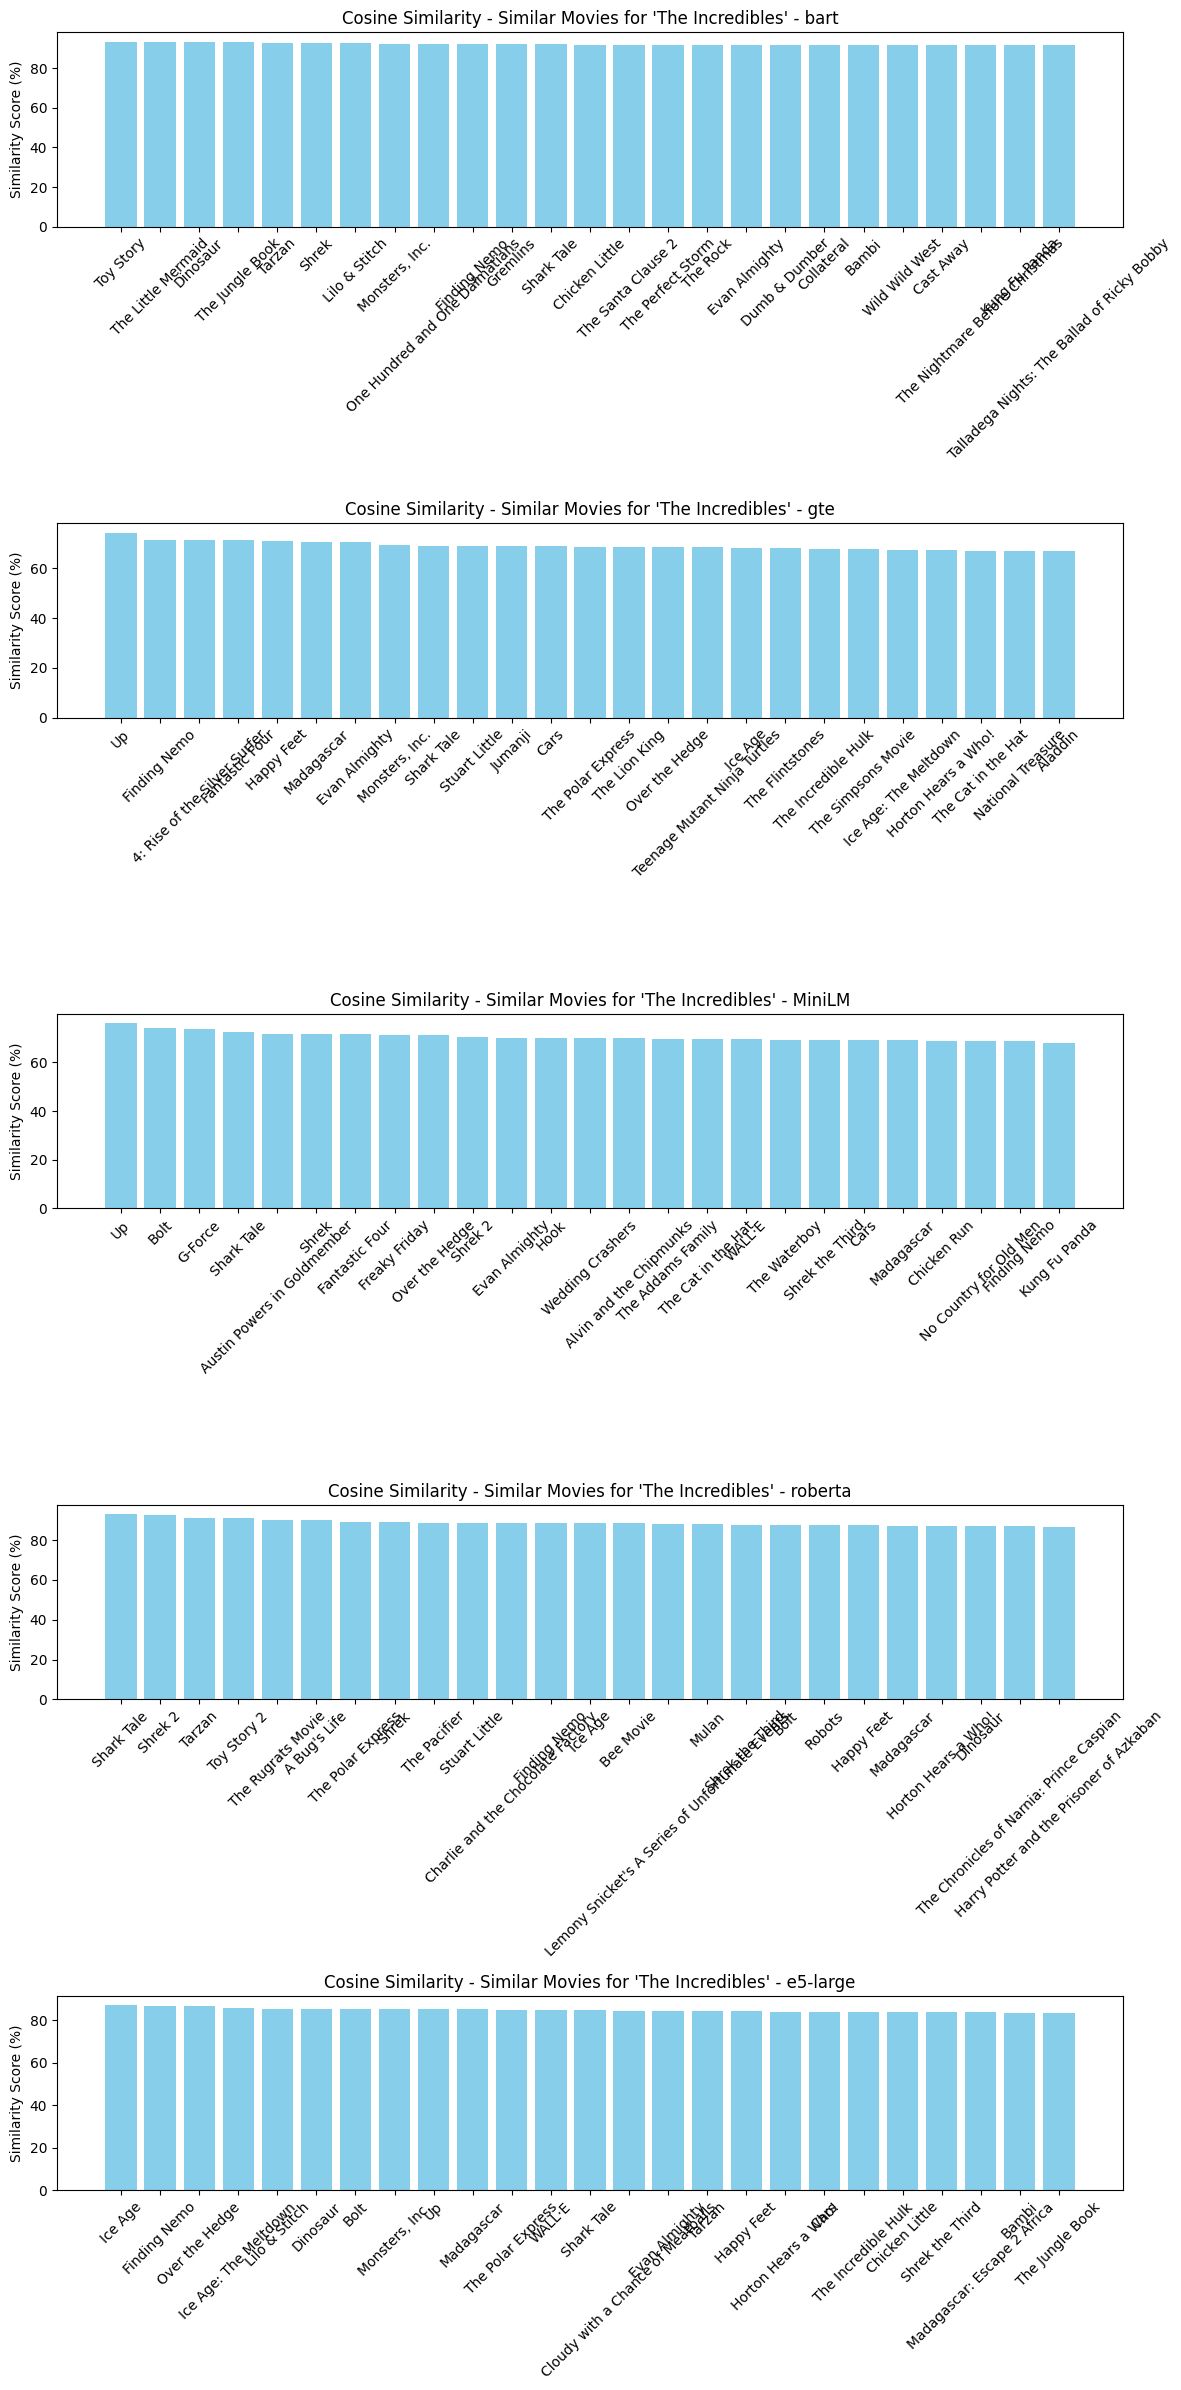

In [28]:
# For cosine similarity
similar_movies_bart = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='bart')
similar_movies_gte = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='gte')
similar_movies_MiniLM = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='MiniLM')
similar_movies_roberta = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='roberta')
similar_movies_e5_large = find_similar_movies_sql(query_movie_title, threshold=0, return_n=25, distance_function='<=>', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_bart, similar_movies_gte, similar_movies_MiniLM, similar_movies_roberta, similar_movies_e5_large], "Cosine Similarity")

# Make comparison with different embeddings with panda

In [29]:
import pandas as pd


most_similar_movie_bart = find_similar_movies_sql(query_movie_title, threshold=0, return_n=1, distance_function='<=>', embedding_type='bart')[0]
most_similar_movie_gte = find_similar_movies_sql(query_movie_title, threshold=0, return_n=1, distance_function='<=>', embedding_type='gte')[0]
most_similar_movie_MiniLM = find_similar_movies_sql(query_movie_title, threshold=0, return_n=1, distance_function='<=>', embedding_type='MiniLM')[0]
most_similar_movie_roberta = find_similar_movies_sql(query_movie_title, threshold=0, return_n=1, distance_function='<=>', embedding_type='roberta')[0]
most_similar_movie_e5_large = find_similar_movies_sql(query_movie_title, threshold=0, return_n=1, distance_function='<=>', embedding_type='e5_large')[0]

most_similar_movie_df = pd.DataFrame({
    'Title': [most_similar_movie_bart[0], most_similar_movie_gte[0], most_similar_movie_MiniLM[0], most_similar_movie_roberta[0], most_similar_movie_e5_large[0]],
    'Similarity Score (%)': [round(most_similar_movie_bart[1] * 100, 3), round(most_similar_movie_gte[1] * 100, 3), round(most_similar_movie_MiniLM[1] * 100, 3), round(most_similar_movie_roberta[1] * 100, 3), round(most_similar_movie_e5_large[1] * 100, 3)]
}, index=list(models.keys()))

print(most_similar_movie_df)

               Title  Similarity Score (%)
bart       Toy Story                93.451
gte               Up                74.388
MiniLM            Up                75.960
roberta   Shark Tale                92.904
e5-large     Ice Age                86.908


# Middle similarity movie

In [30]:
# find the most similar movie median
def find_most_similar_movie_median(title, threshold=0, distance_function='<->', embedding_type='bart', n=631):
    similar_movies = find_similar_movies_sql(title, threshold, n, distance_function, embedding_type)
    if similar_movies:
        similarities = [sim for _, sim in similar_movies]
        # find median and return index
        median_index = np.argsort(similarities)[len(similarities) // 2]
        return similar_movies[median_index]
    else:
        return None

most_similar_movie_median_bart = find_most_similar_movie_median(query_movie_title, threshold=0, distance_function='<=>', embedding_type='bart')
most_similar_movie_median_gte = find_most_similar_movie_median(query_movie_title, threshold=0, distance_function='<=>', embedding_type='gte')
most_similar_movie_median_MiniLM = find_most_similar_movie_median(query_movie_title, threshold=0, distance_function='<=>', embedding_type='MiniLM')
most_similar_movie_median_roberta = find_most_similar_movie_median(query_movie_title, threshold=0, distance_function='<=>', embedding_type='roberta')
most_similar_movie_median_e5_large = find_most_similar_movie_median(query_movie_title, threshold=0, distance_function='<=>', embedding_type='e5_large')


most_similar_movie_median_df =  pd.DataFrame({
    'Title': [most_similar_movie_median_bart[0], most_similar_movie_median_gte[0], most_similar_movie_median_MiniLM[0], most_similar_movie_median_roberta[0], most_similar_movie_median_e5_large[0]],
    'Similarity Score (%)': [round(most_similar_movie_median_bart[1] * 100, 3), round(most_similar_movie_median_gte[1] * 100, 3), round(most_similar_movie_median_MiniLM[1] * 100, 3), round(most_similar_movie_median_roberta[1] * 100, 3), round(most_similar_movie_median_e5_large[1] * 100, 3)]
}, index=list(models.keys()))

print(most_similar_movie_median_df)

                         Title  Similarity Score (%)
bart            101 Dalmatians                87.738
gte            Blades of Glory                57.274
MiniLM    The Bourne Ultimatum                52.563
roberta                  Speed                75.812
e5-large               Titanic                78.170


# Find the least similar movie

In [31]:
# find the least similar movie
def find_least_similar_movie(title, threshold=0.1, distance_function='<->', embedding_type='bart', return_n=631):
    similar_movies = find_similar_movies_sql(title, threshold, return_n, distance_function, embedding_type)
    if similar_movies:
        return similar_movies[-1]
    else:
        return None

least_similar_movie_bart = find_least_similar_movie(query_movie_title, threshold=0, distance_function='<=>', embedding_type='bart')
least_similar_movie_gte = find_least_similar_movie(query_movie_title, threshold=0, distance_function='<=>', embedding_type='gte')
least_similar_movie_MiniLM = find_least_similar_movie(query_movie_title, threshold=0, distance_function='<=>', embedding_type='MiniLM')
least_similar_movie_roberta = find_least_similar_movie(query_movie_title, threshold=0, distance_function='<=>', embedding_type='roberta')
least_similar_movie_e5_large = find_least_similar_movie(query_movie_title, threshold=0, distance_function='<=>', embedding_type='e5_large')

least_similar_movie_df = pd.DataFrame({
    'Title': [least_similar_movie_bart[0], least_similar_movie_gte[0], least_similar_movie_MiniLM[0], least_similar_movie_roberta[0], least_similar_movie_e5_large[0]],
    'Similarity Score (%)': [round(least_similar_movie_bart[1] * 100, 3), round(least_similar_movie_gte[1] * 100, 3), round(least_similar_movie_MiniLM[1] * 100, 3), round(least_similar_movie_roberta[1] * 100, 3), round(least_similar_movie_e5_large[1] * 100, 3)]
}, index=list(models.keys()))

print(least_similar_movie_df)

                                     Title  Similarity Score (%)
bart      Il buono, il brutto, il cattivo.                61.033
gte                      The Lady Vanishes                42.767
MiniLM                 Le notti di Cabiria                 9.650
roberta                    Smultronstället                52.263
e5-large               Ladri di biciclette                68.094


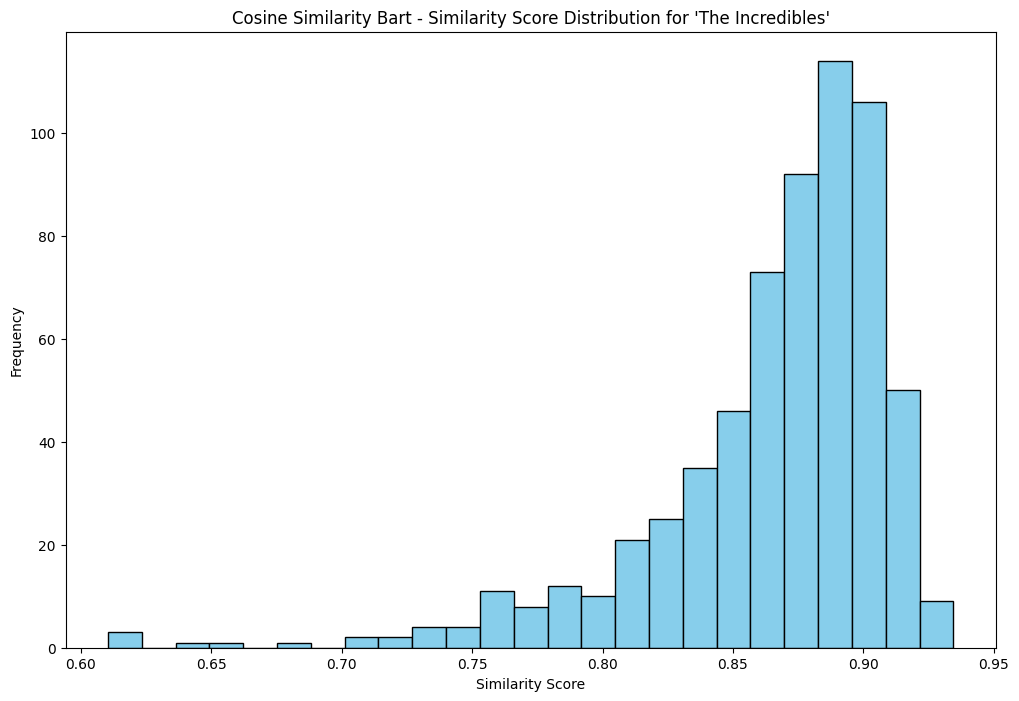

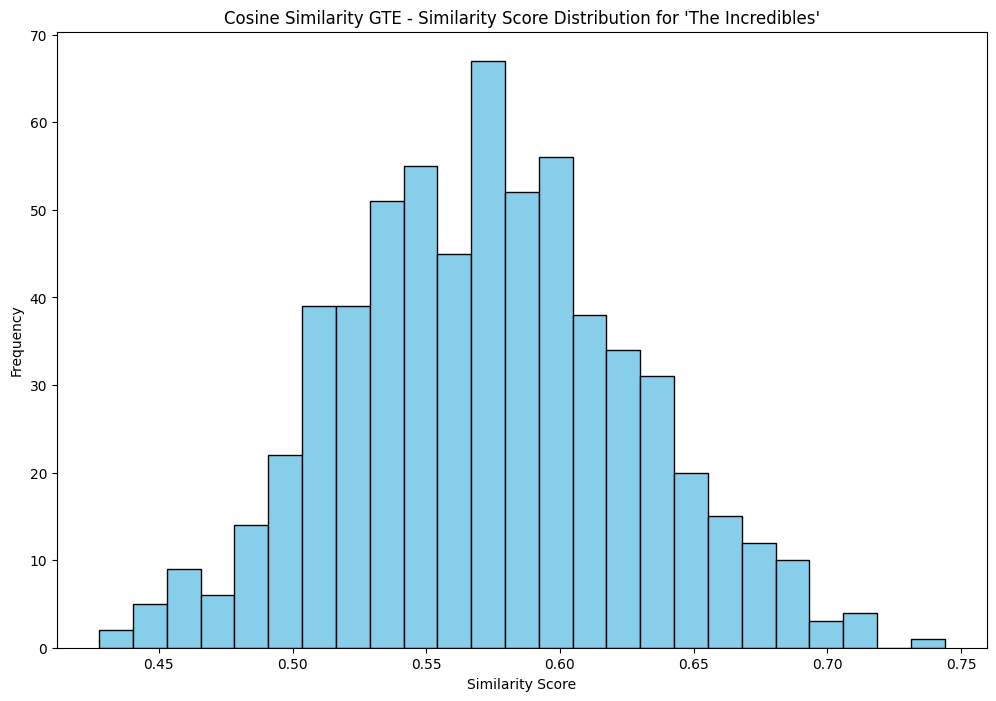

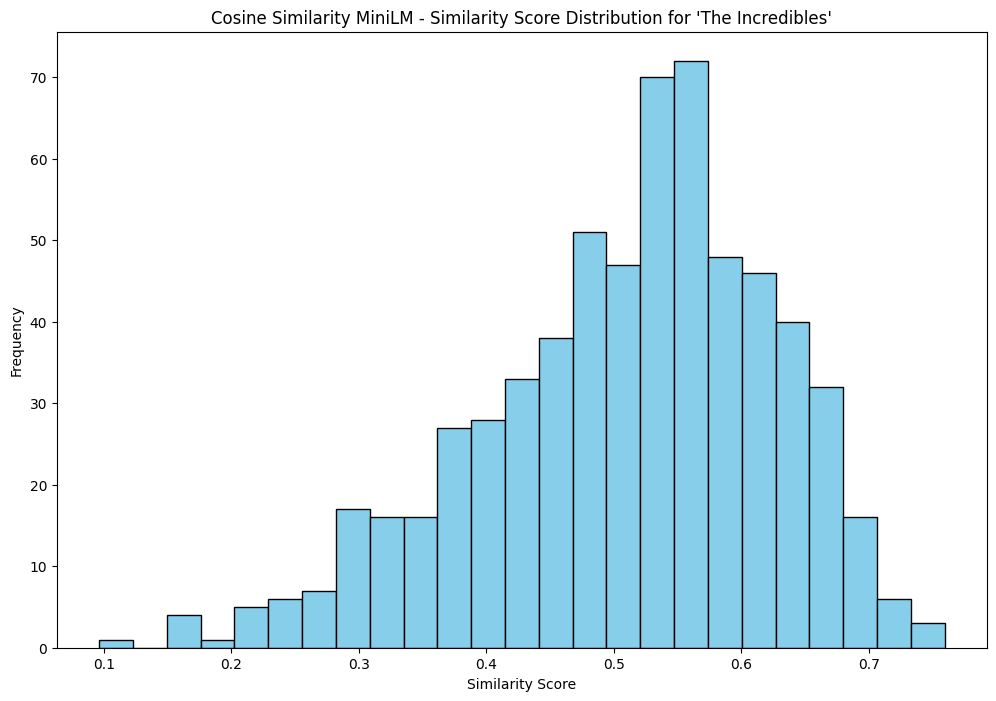

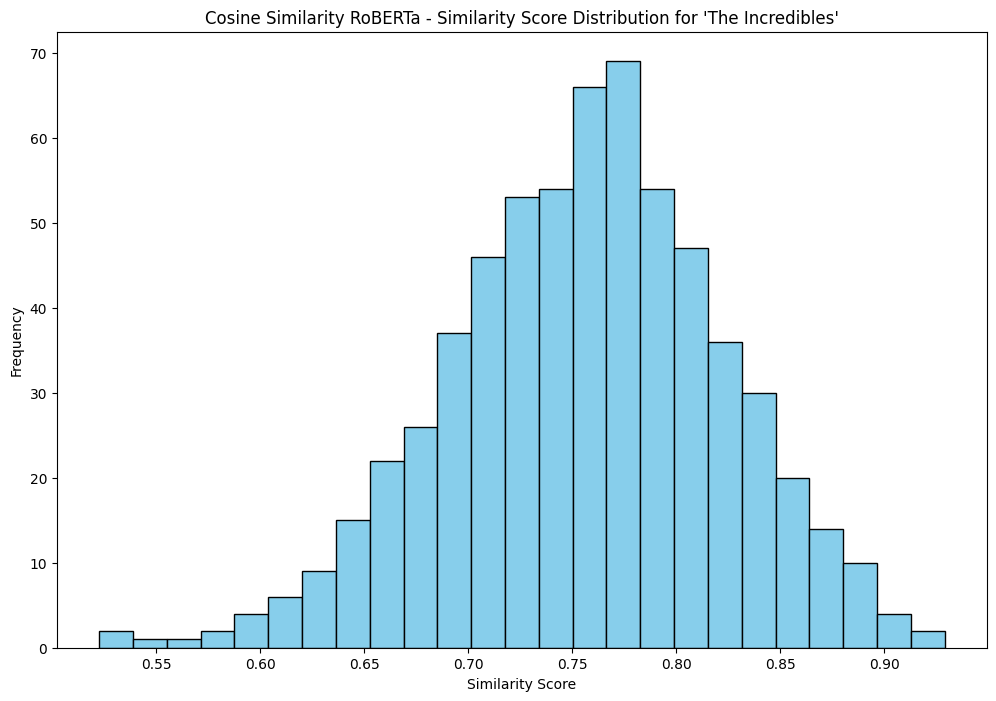

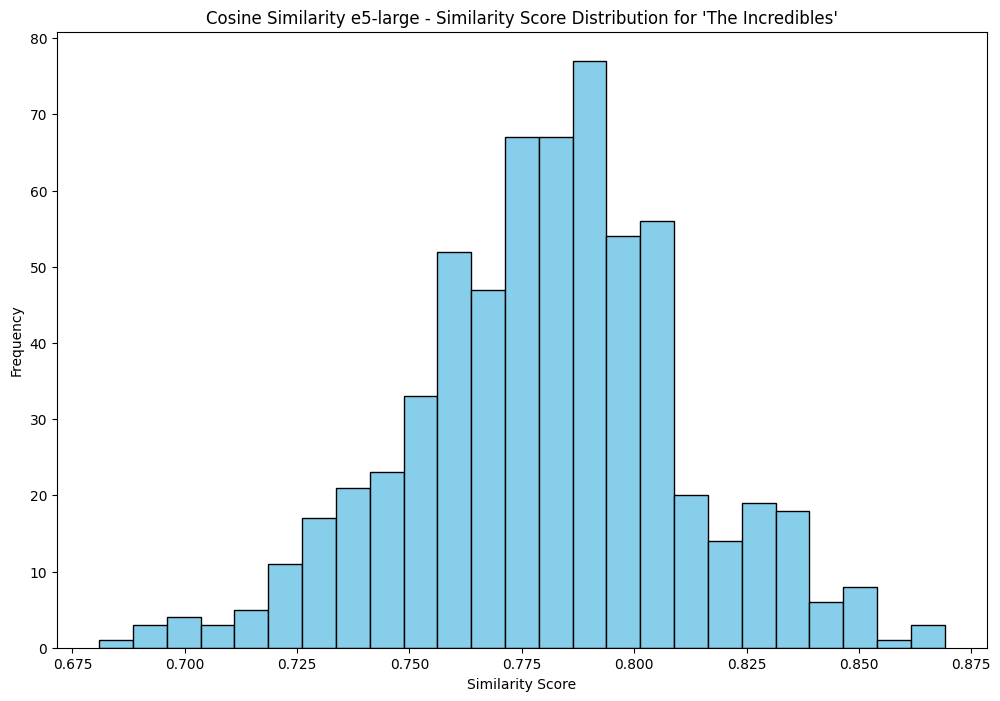

In [32]:
# show distribution of similarity scores
def plot_similarity_distribution(similar_movies, title):
    similarities = [sim[1] for sim in similar_movies]
    plt.figure(figsize=(12, 8))
    plt.hist(similarities, bins=25, color='skyblue', edgecolor='black')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title(f"{title} - Similarity Score Distribution for '{query_movie_title}'")
    plt.show()

similar_movies_bart = find_similar_movies_sql(query_movie_title, threshold=0, return_n=631, distance_function='<=>', embedding_type='bart')
similar_movies_gte = find_similar_movies_sql(query_movie_title, threshold=0, return_n=631, distance_function='<=>', embedding_type='gte')
similar_movies_MiniLM = find_similar_movies_sql(query_movie_title, threshold=0, return_n=631, distance_function='<=>', embedding_type='MiniLM')
similar_movies_roberta = find_similar_movies_sql(query_movie_title, threshold=0, return_n=631, distance_function='<=>', embedding_type='roberta')
similar_movies_e5_large = find_similar_movies_sql(query_movie_title, threshold=0, return_n=631, distance_function='<=>', embedding_type='e5_large')


plot_similarity_distribution(similar_movies_bart, 'Cosine Similarity Bart')
plot_similarity_distribution(similar_movies_gte, 'Cosine Similarity GTE')
plot_similarity_distribution(similar_movies_MiniLM, 'Cosine Similarity MiniLM')
plot_similarity_distribution(similar_movies_roberta, 'Cosine Similarity RoBERTa')
plot_similarity_distribution(similar_movies_e5_large, 'Cosine Similarity e5-large')

# Python

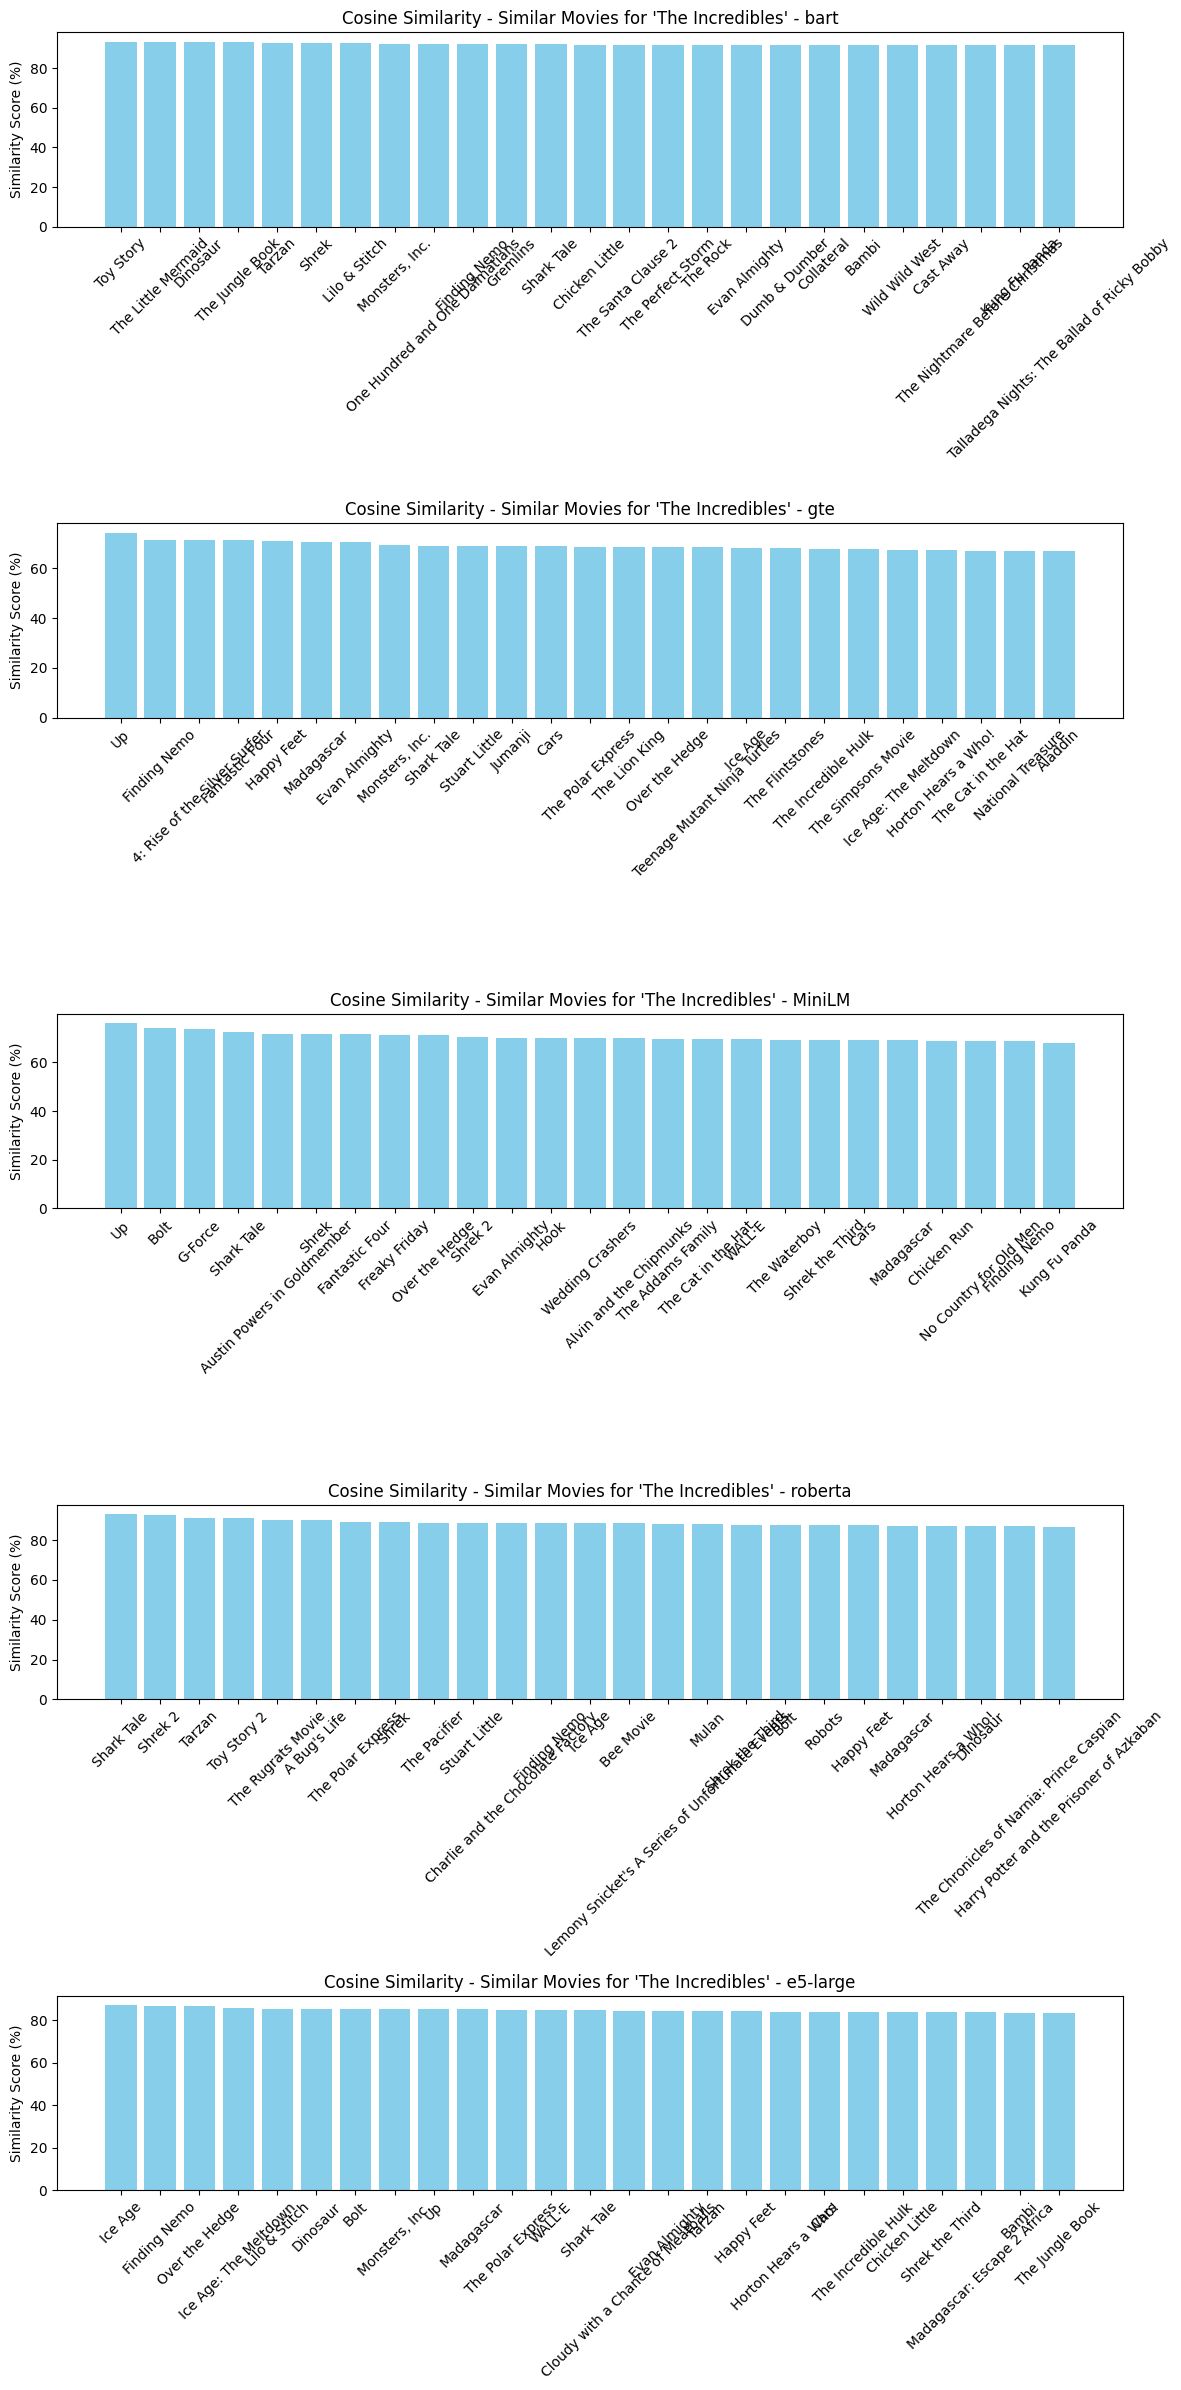

In [33]:
# For cosine similarity
similar_movies_cosine_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='bart')
similar_movies_cosine_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='gte')
similar_movies_cosine_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='MiniLM')
similar_movies_cosine_roberta = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='roberta')
similar_movies_cosine_e5_large = find_similar_movies(query_movie_title, threshold=0, distance_function='cosine_similarity', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_cosine_bart, similar_movies_cosine_gte, similar_movies_cosine_MiniLM, similar_movies_cosine_roberta, similar_movies_cosine_e5_large], "Cosine Similarity")

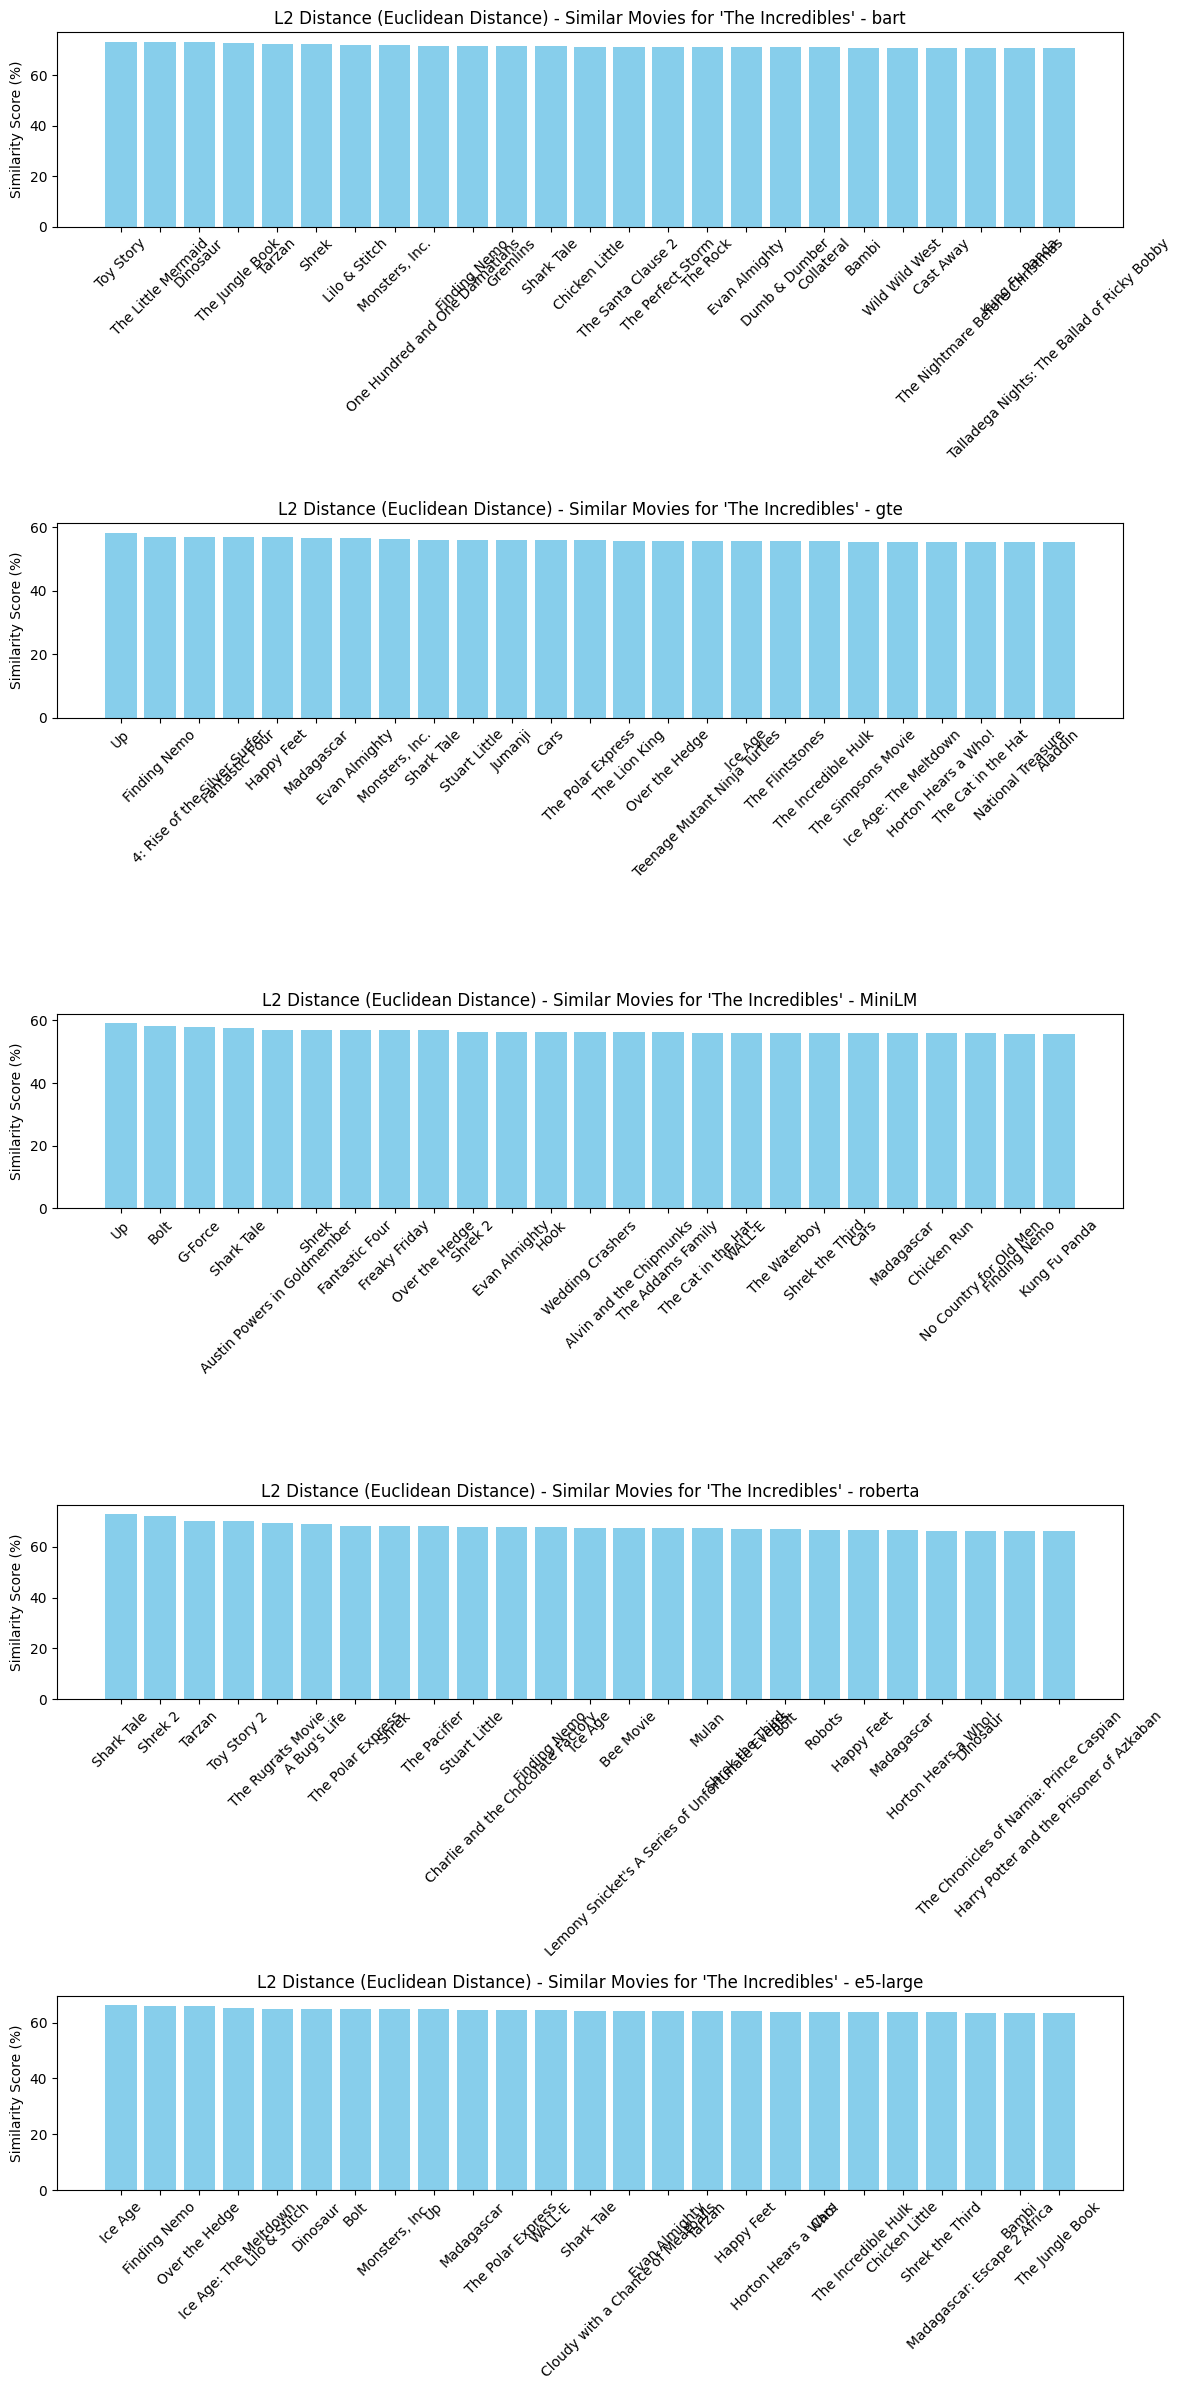

In [34]:
# For L2 Distance (Euclidean Distance)
similar_movies_l2_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='bart')
similar_movies_l2_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='gte')
similar_movies_l2_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='MiniLM')
similar_movies_l2_roberta = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='roberta')
similar_movies_l2_e5_large = find_similar_movies(query_movie_title, threshold=0, distance_function='euclidean_distance', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_l2_bart, similar_movies_l2_gte, similar_movies_l2_MiniLM, similar_movies_l2_roberta, similar_movies_l2_e5_large], "L2 Distance (Euclidean Distance)")

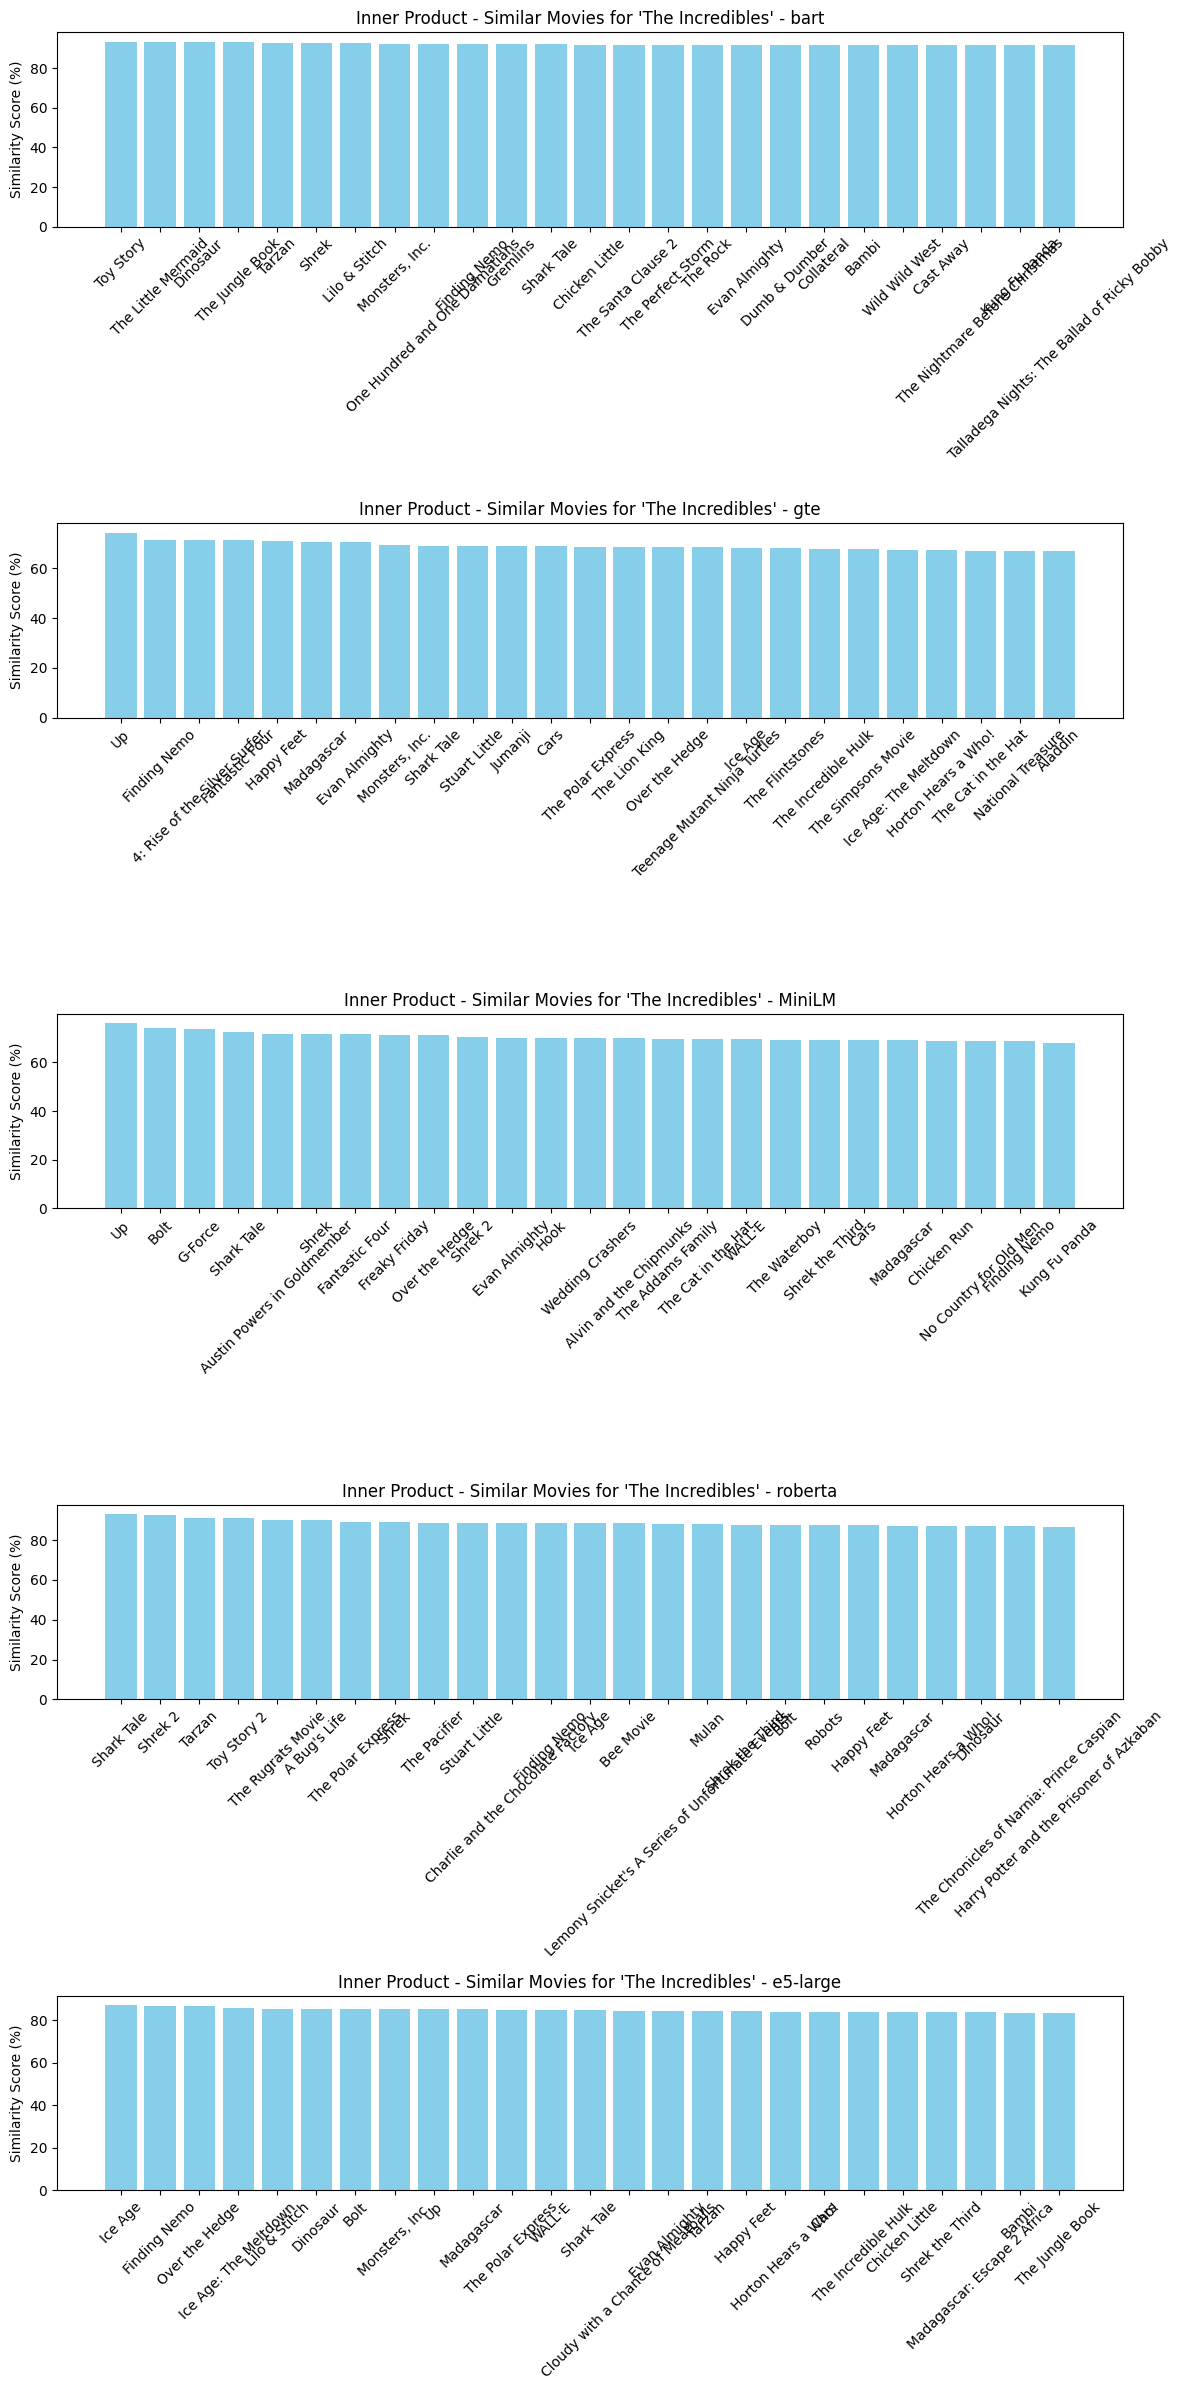

In [35]:
# For Inner Product
similar_movies_inner_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='bart')
similar_movies_inner_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='gte')
similar_movies_inner_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='MiniLM')
similar_movies_inner_roberta = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='roberta')
similar_movies_inner_e5_large = find_similar_movies(query_movie_title, threshold=0, distance_function='inner_product', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_inner_bart, similar_movies_inner_gte, similar_movies_inner_MiniLM, similar_movies_inner_roberta, similar_movies_inner_e5_large], "Inner Product")

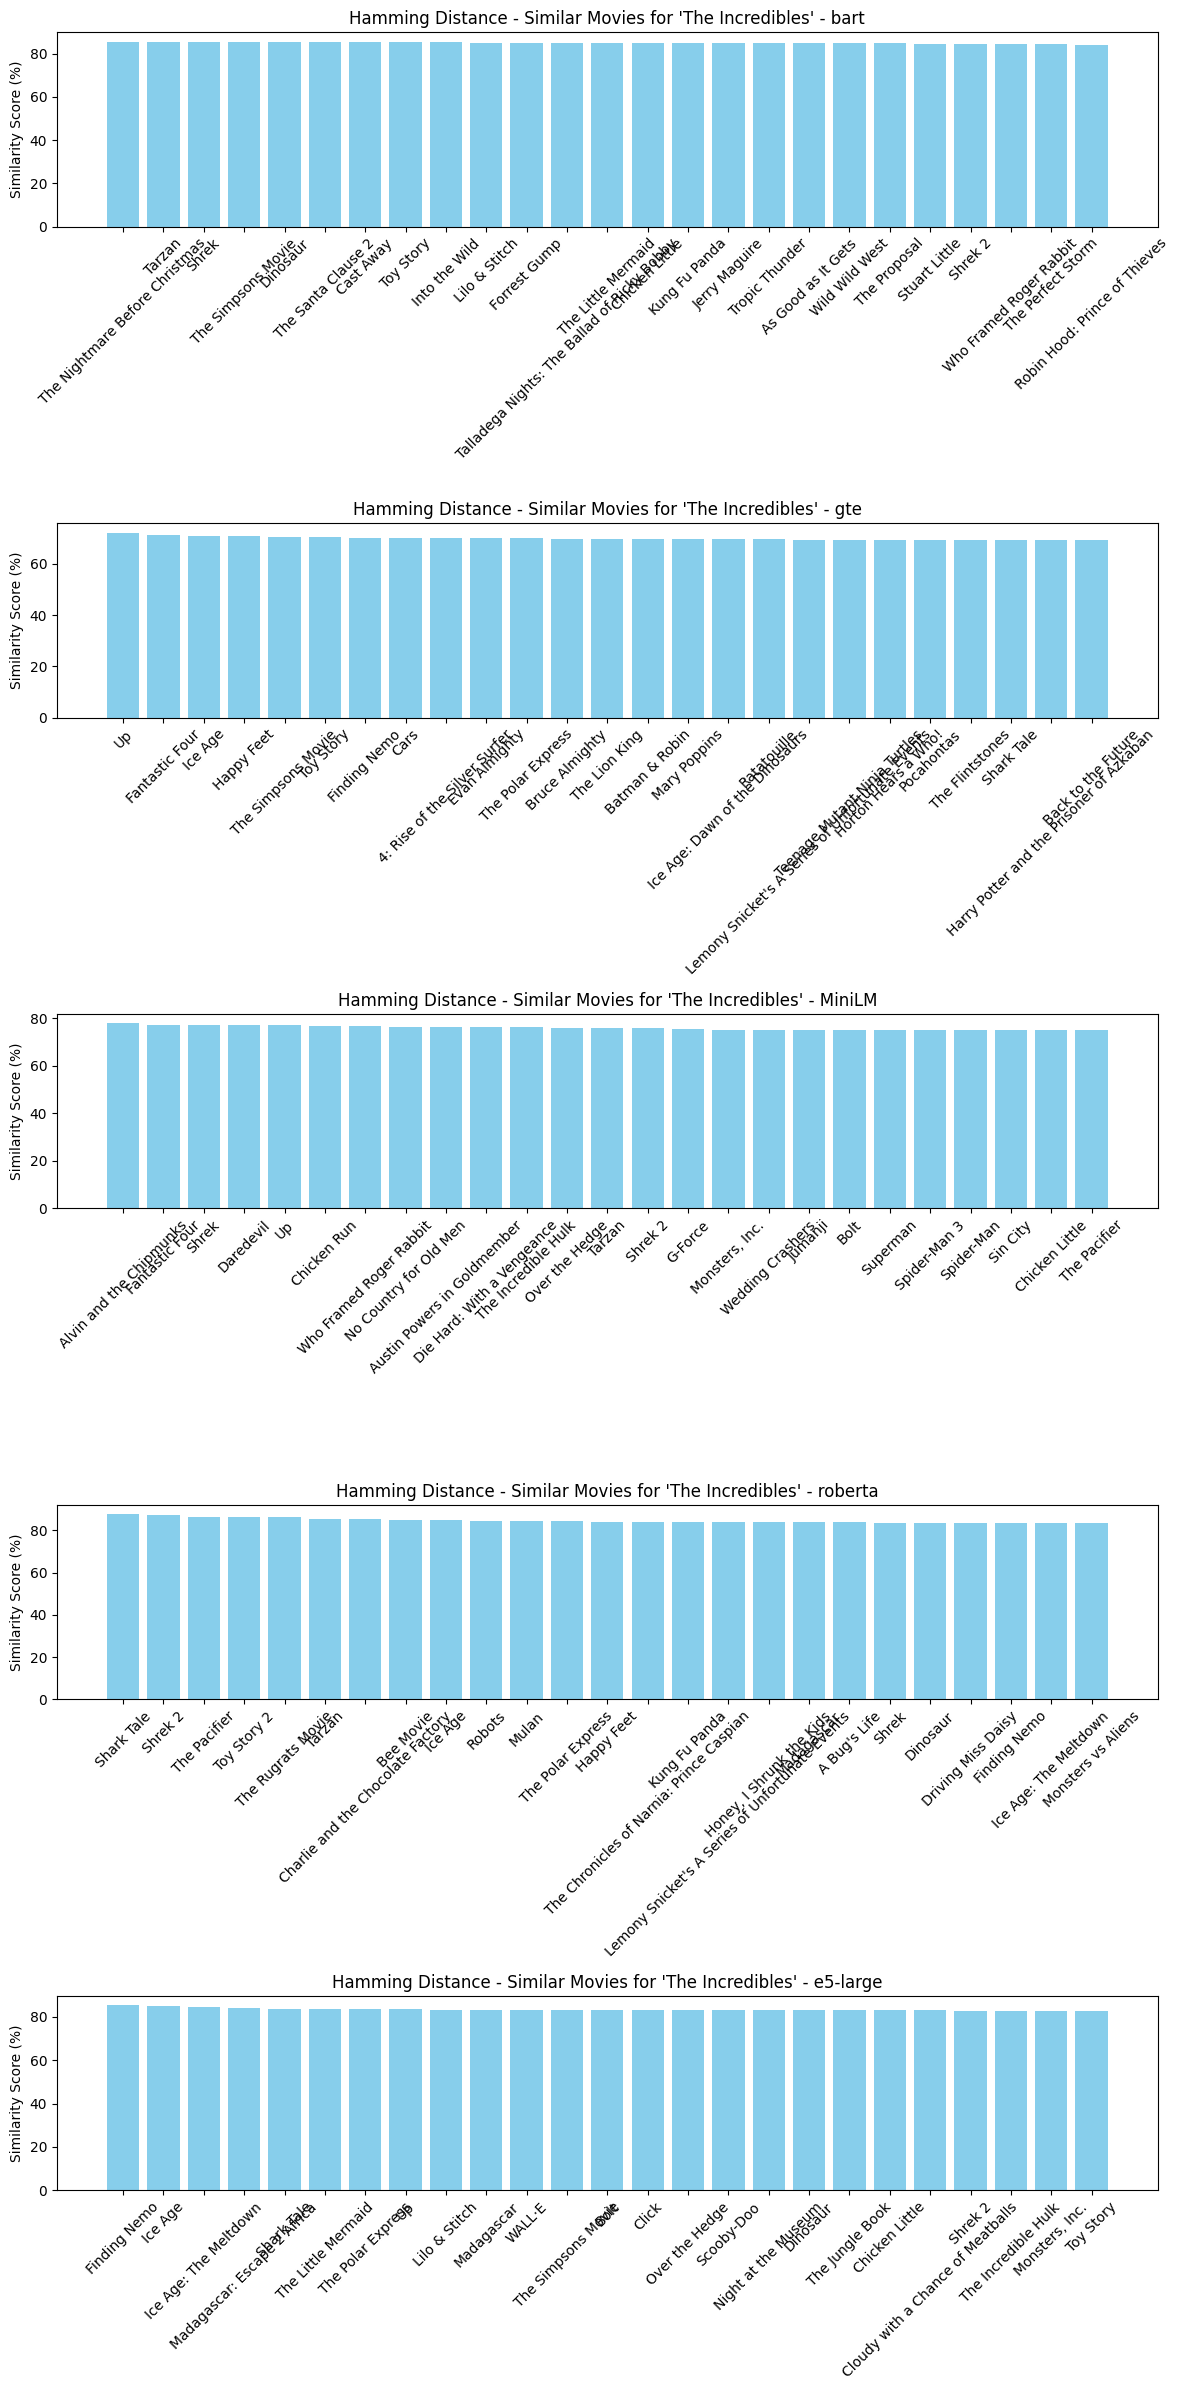

In [36]:
# For Hamming Distance
similar_movies_hamming_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='bart')
similar_movies_hamming_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='gte')
similar_movies_hamming_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='MiniLM')
similar_movies_hamming_roberta = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='roberta')
similar_movies_hamming_e5_large = find_similar_movies(query_movie_title, threshold=0, distance_function='hamming_distance', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_hamming_bart, similar_movies_hamming_gte, similar_movies_hamming_MiniLM, similar_movies_hamming_roberta, similar_movies_hamming_e5_large], "Hamming Distance")

C:\Users\antoi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\antoi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\antoi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\antoi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\antoi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\pairwise.py:2350: DataConversionWarning: Data was converted to boolean for

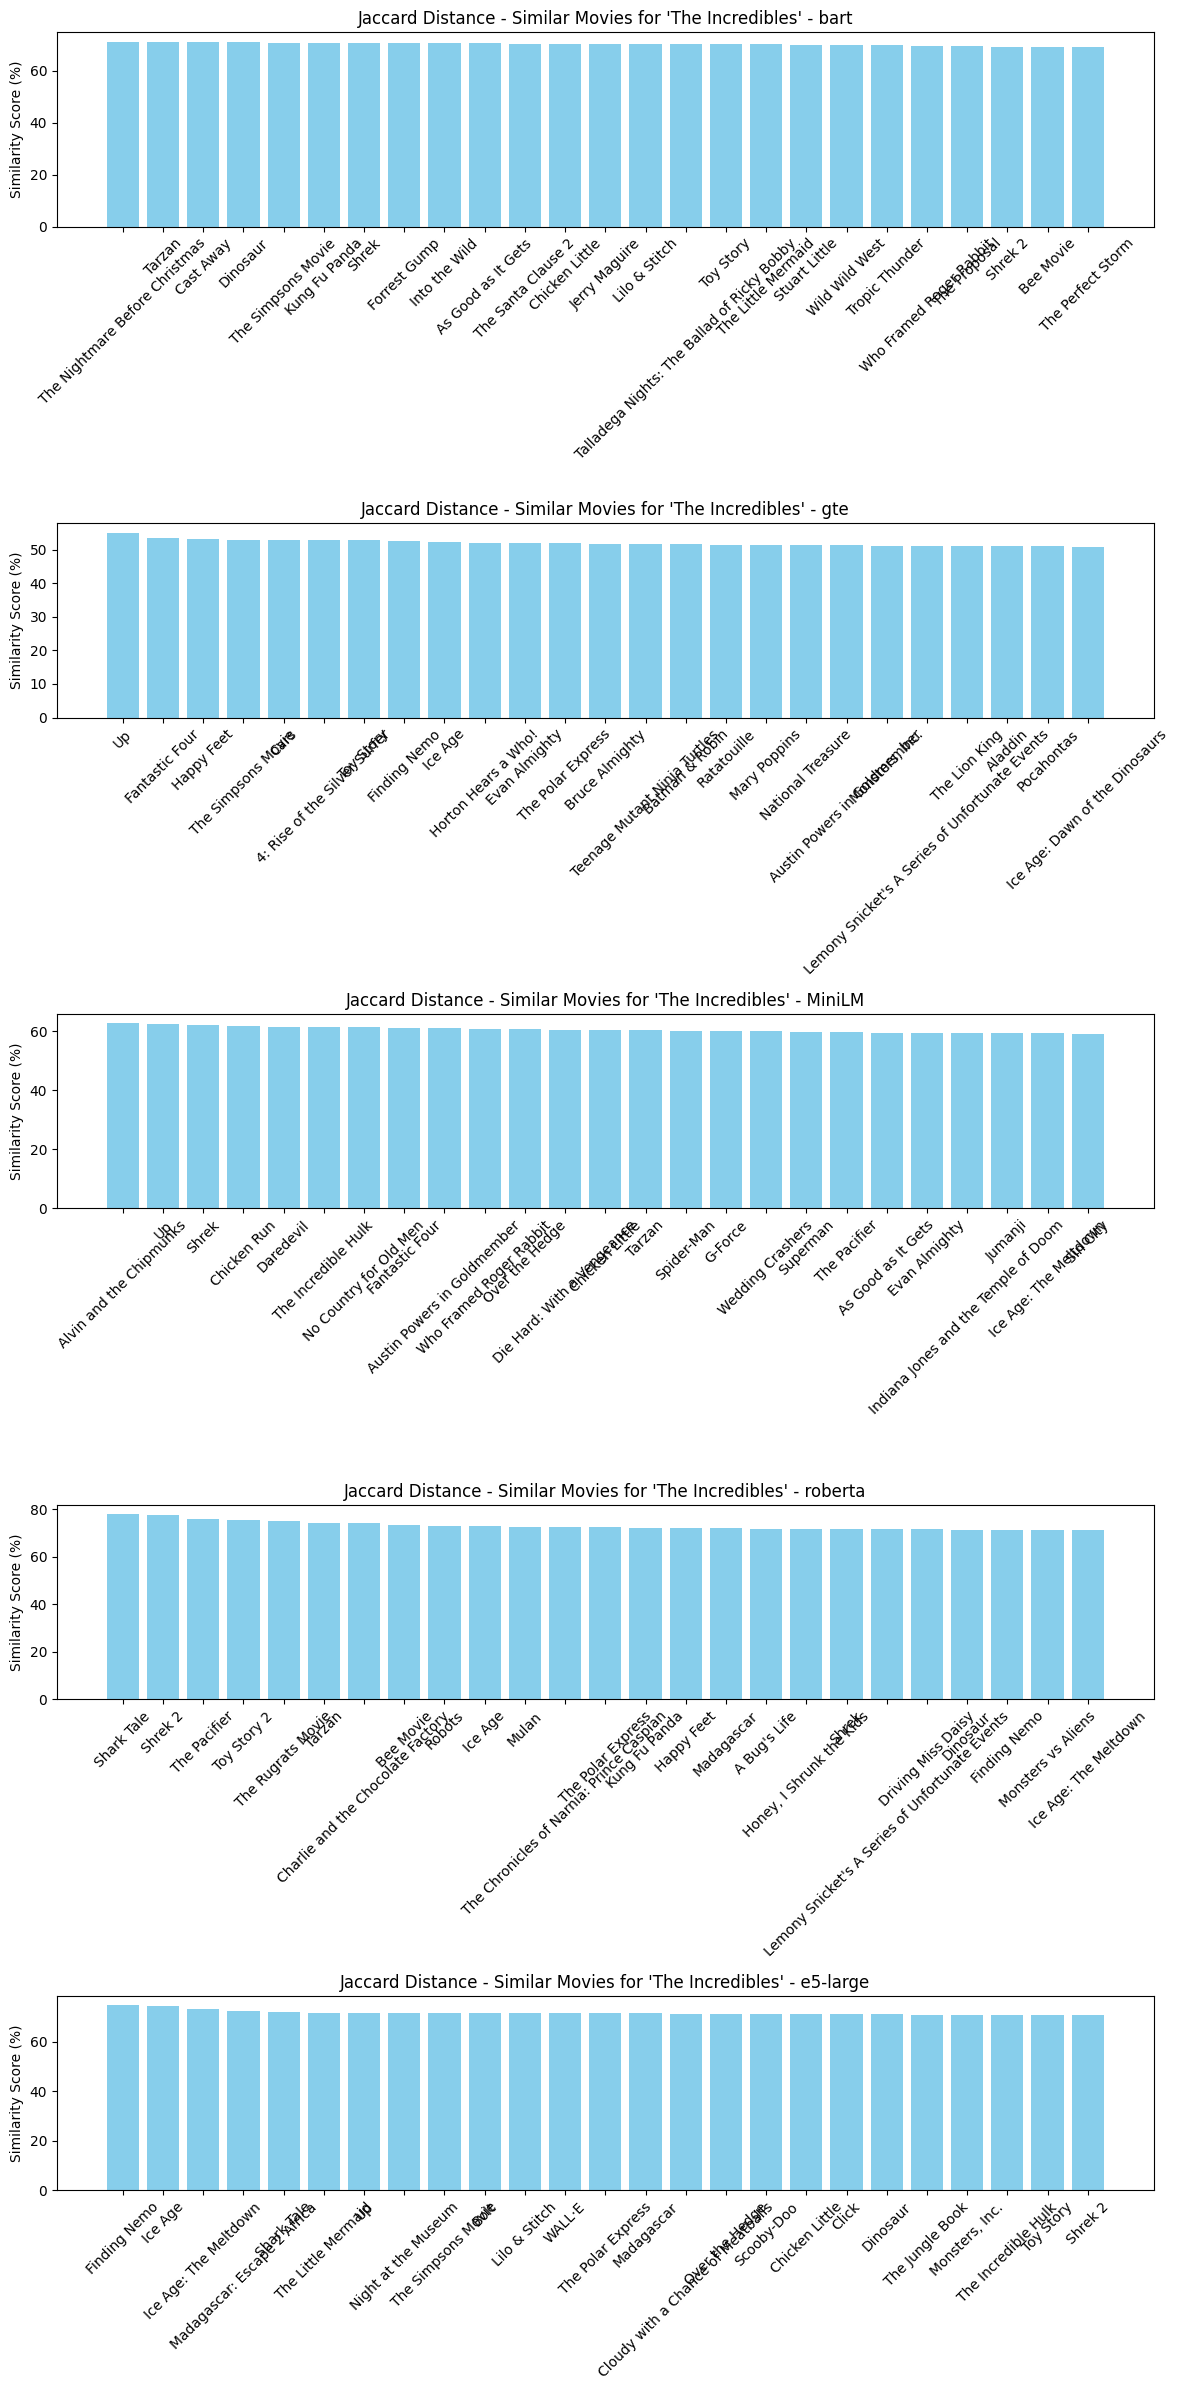

In [37]:
# For Jaccard Distance
similar_movies_jaccard_bart = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='bart')
similar_movies_jaccard_gte = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='gte')
similar_movies_jaccard_MiniLM = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='MiniLM')
similar_movies_jaccard_roberta = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='roberta')
similar_movies_jaccard_e5_large = find_similar_movies(query_movie_title, threshold=0, distance_function='jaccard_distance', embedding_type='e5_large')
plot_compare_similar_movies_embedding([similar_movies_jaccard_bart, similar_movies_jaccard_gte, similar_movies_jaccard_MiniLM, similar_movies_jaccard_roberta, similar_movies_jaccard_e5_large], "Jaccard Distance")